In [ ]:
install.packages("ggplot2")
install.packages("infotheo")
install.packages("carData")
install.packages("forecast")
install.packages("psych")
install.packages("TSA")
install.packages("chron")
install.packages("caTools")
install.packages("caret")
install.packages('car')
install.packages('corrplot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppEigen’, ‘pbkrtest’, ‘lme4’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(carData)
library(magrittr)
library(dplyr)
library(tidyr)
library(infotheo)
library(forecast)
library(MASS)
library(psych)
library(TSA)
library(forecast)
library(chron)
library(caTools)
library(caret)
library(ggplot2)
library(car)
library(corrplot)


Attaching package: ‘car’


The following object is masked from ‘package:psych’:

    logit


The following object is masked from ‘package:dplyr’:

    recode


corrplot 0.95 loaded



In [ ]:
# import dataset
setwd("/content/")
bike <- read.csv("SeoulBikeData.csv",check.names = F)

# set new column names
bike <- setNames(bike, c("date","bike_count","hour","temp","humidity","wind_speed","visibility","dew_point_temp",
                         "solar_radiation","rainfall","snowfall","seasons","holiday","functioning_day"))

# Setting categorical values

bike$hour <- factor(bike$hour)
bike$seasons <- factor(bike$seasons)
bike$holiday <- factor(bike$holiday)
bike$functioning_day <- factor(bike$functioning_day)

head(bike)

,date,bike_count,hour,temp,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
,<chr>,<int>,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes
2,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes
3,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes
4,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes
5,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes
6,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes


In [ ]:
summary(bike$functioning_day)

No  Yes 
 295 8465

According to the summary statistics of functioning_day, there are 295 non-functioning days in the dataset. These day will have zero bike counts.

# Important Features

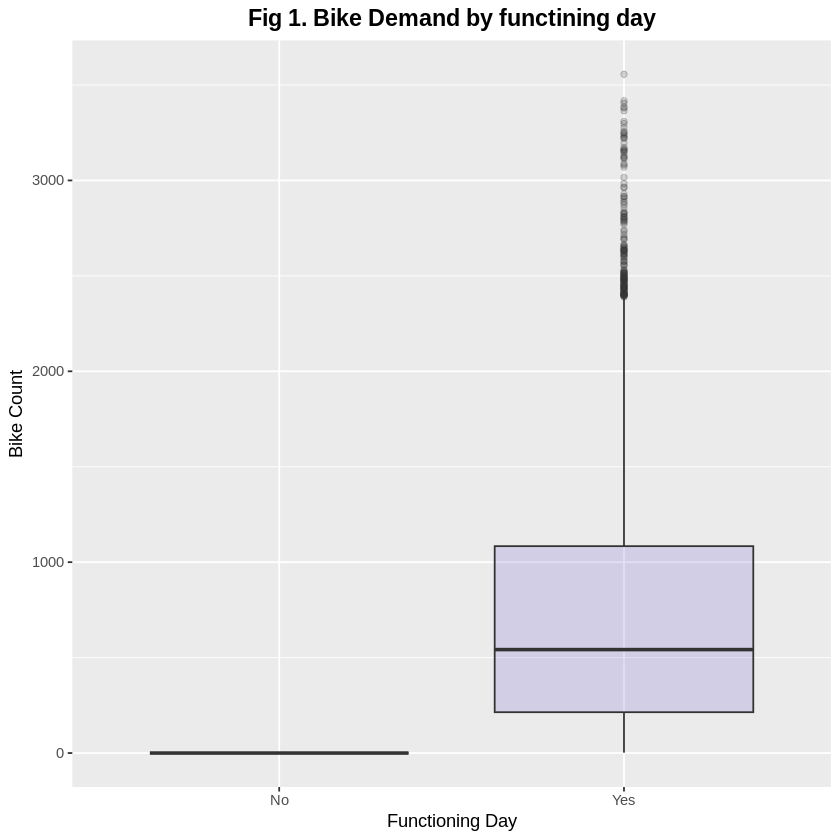

In [ ]:
fig1 <- ggplot(bike, aes(x = as.factor(functioning_day), y = bike_count)) +
              geom_boxplot(fill="slateblue", alpha=0.2) +
              ggtitle("Fig 1. Bike Demand by functining day") +
              xlab("Functioning Day") + ylab("Bike Count")

fig1 + theme(plot.title = element_text(size=14, face="bold", hjust=0.5))

The bikes will not be available to rent during non functioning days and therefore, bike count will be zero on non functioning day as no one will be able to rent the bicycles as seen in Fig 1. Therefore, non-functioning day data points are deleted from the dataset as this is not relevent to our purpose. The dataset is now left with **8465 data points**.

In [ ]:
# Deleting rows when it is non-functioning day
bike<-bike[!(bike$functioning_day=="No"),]

# removing unused columns
bike <- subset(bike, select = - c(functioning_day))

summary(bike)

     date             bike_count          hour           temp       
 Length:8465        Min.   :   2.0   7      : 353   Min.   :-17.80  
 Class :character   1st Qu.: 214.0   8      : 353   1st Qu.:  3.00  
 Mode  :character   Median : 542.0   9      : 353   Median : 13.50  
                    Mean   : 729.2   10     : 353   Mean   : 12.77  
                    3rd Qu.:1084.0   11     : 353   3rd Qu.: 22.70  
                    Max.   :3556.0   12     : 353   Max.   : 39.40  
                                     (Other):6347                   
    humidity       wind_speed      visibility   dew_point_temp   
 Min.   : 0.00   Min.   :0.000   Min.   :  27   Min.   :-30.600  
 1st Qu.:42.00   1st Qu.:0.900   1st Qu.: 935   1st Qu.: -5.100  
 Median :57.00   Median :1.500   Median :1690   Median :  4.700  
 Mean   :58.15   Mean   :1.726   Mean   :1434   Mean   :  3.945  
 3rd Qu.:74.00   3rd Qu.:2.300   3rd Qu.:2000   3rd Qu.: 15.200  
 Max.   :98.00   Max.   :7.400   Max.   :2000   Max.

Summary statistics of the dataset shows general idea of how the data without non-functioning days look like. This will be further analysed with bar plots and histograms. Fig 2. Hourly Bike Count Bar Plot indicates the numbers of bikes rented by hour.

The mean demand is lower than 500 bike counts for hours between 1 am and 6 am.

We can see huge spike in boxplot at 8 which is 8 am in the morning, and we can see slowly increasing parretn in boxplot throughout daytime reaching huge peak at 18 which is 6pm.

Also, bike renting starts to decrease after 18 and reached lowest at 4. All the am hours except 8 am and 7 am has deman of lower than 1000 bike counts. Therefore, we take **am hours as low deman hours** and **pm hours as high demand hours**.

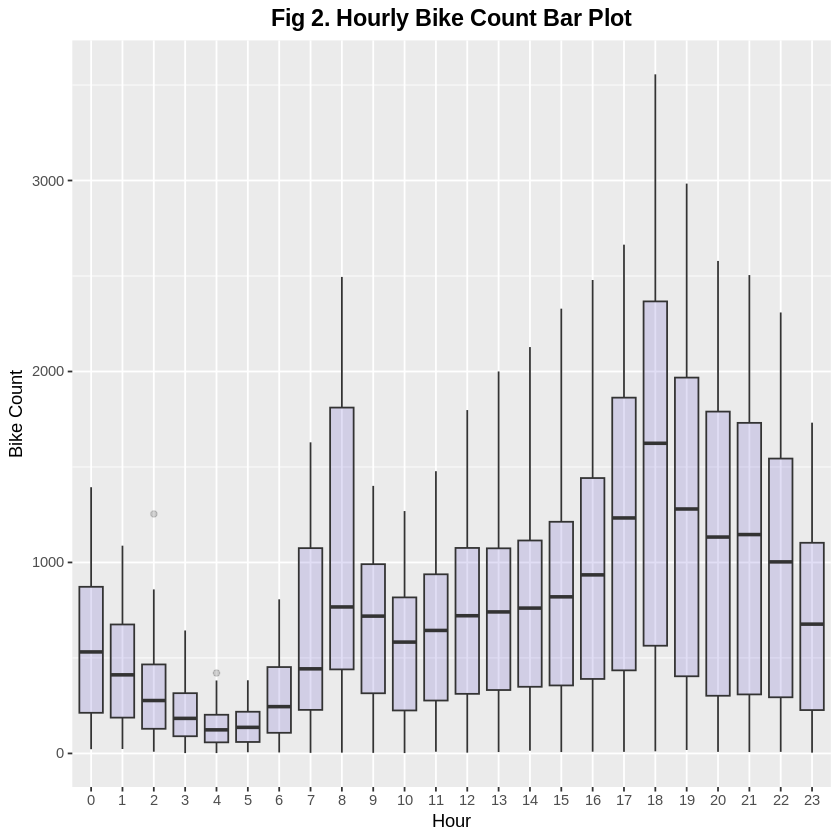

In [ ]:
fig2<- ggplot(bike, aes(x = as.factor(hour) , y = bike_count)) +
              geom_boxplot(fill="slateblue", alpha=0.2) +
              ggtitle("Fig 2. Hourly Bike Count Bar Plot") +
              xlab("Hour") + ylab("Bike Count")

fig2 + theme(plot.title = element_text(size=14, face="bold", hjust=0.5))

From Fig 3. Seasonal Bike Count Bar Plot, we can easily infer that during **better weather times** such as summer, people **usually prefer to cycle more** and in **winters** bikes are rented **lowest** with well lower than 500 bike counts in demand. This may be due to cold weather as well as snow during winter.

There are a few outliers with higher density than the rest of the seasons where bike demand in Winter is over 500. This may be some underlying reasons such as the day having better weather than other days in winter. In Autumn, bike demand is higher than Spring though we were expecting the demand to be higher in Spring than in Autumn. This may be due to having more rainy days in Spring than in Autumn.

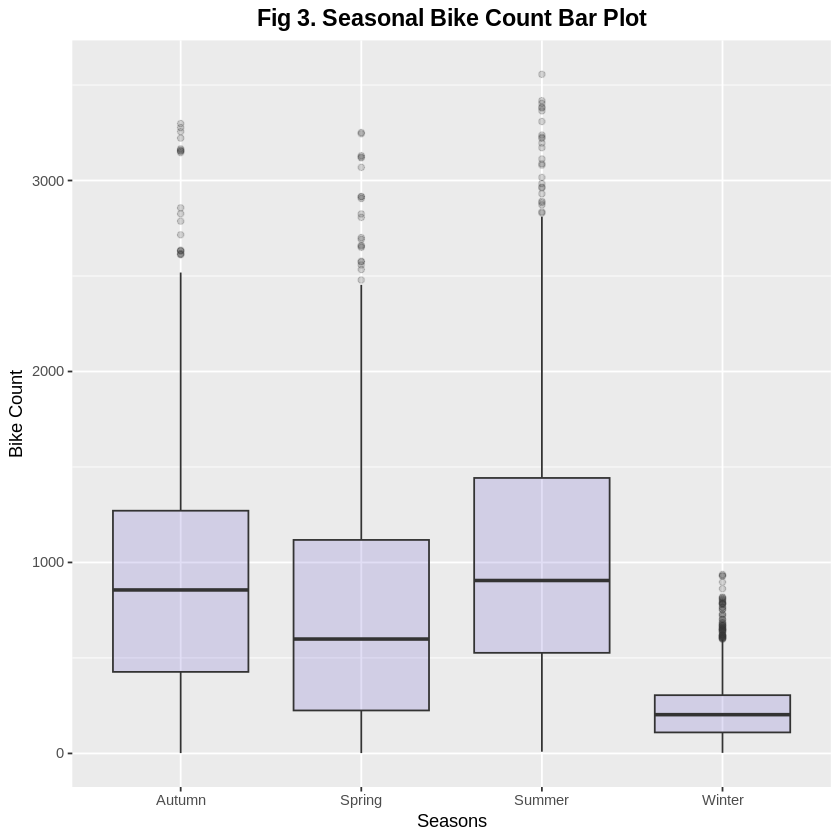

In [ ]:
fig3 <- ggplot(bike, aes(x = as.factor(seasons), y = bike_count)) +
               geom_boxplot(fill="slateblue", alpha=0.2) +
               ggtitle("Fig 3. Seasonal Bike Count Bar Plot") +
               xlab("Seasons") + ylab("Bike Count")

fig3 + theme(plot.title = element_text(size=14, face="bold", hjust=0.5))

According to figure 4, we can determine that the demand for bike is higher on non holiday days, which means mostly our users might be renting bikes for other reasons than for recreational purposes.

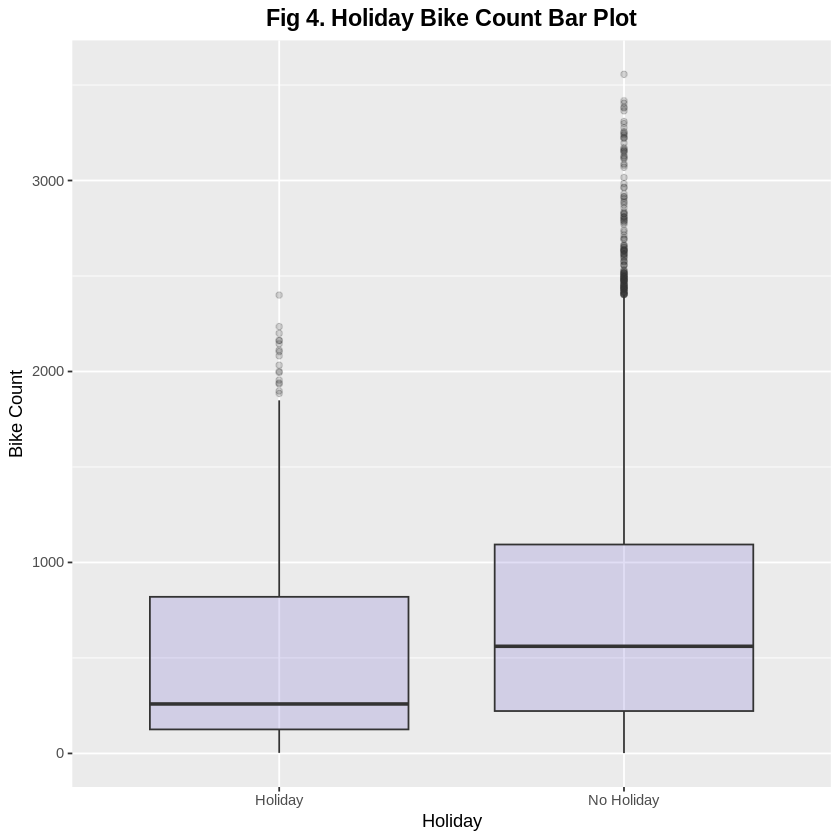

In [ ]:
fig4 <- ggplot(bike, aes(x = as.factor(holiday), y = bike_count)) + geom_boxplot(fill="slateblue", alpha=0.2) + ggtitle("Fig 4. Holiday Bike Count Bar Plot") +  xlab("Holiday") + ylab("Bike Count")
fig4 + theme(plot.title = element_text(size=14, face="bold", hjust=0.5))

# Correlation Matrix

In [ ]:
# correlation matrix of dataset
cor_df <- data.frame(bike$bike_count, as.integer(bike$hour), bike$temp, bike$humidity, bike$wind_speed, bike$visibility, bike$dew_point, bike$solar_radiation, bike$rainfall, bike$snowfall)
cor_matrix <- (cor(cor_df))

cor_matrix[order(-cor_matrix[,1]), ]

,bike.bike_count,as.integer.bike.hour.,bike.temp,bike.humidity,bike.wind_speed,bike.visibility,bike.dew_point,bike.solar_radiation,bike.rainfall,bike.snowfall
bike.bike_count,1.0000000,0.425255882,0.56274017,-0.2019727,0.125021946,0.21232278,0.400262829,0.27386155,-0.128626093,-0.151610753
bike.temp,0.5627402,0.122741816,1.00000000,0.1664252,-0.038480848,0.02826206,0.914466952,0.35484355,0.052148891,-0.217745811
as.integer.bike.hour.,0.4252559,1.000000000,0.12274182,-0.2359372,0.287779819,0.10386932,0.004691479,0.14465848,0.014344645,-0.022082499
bike.dew_point,0.4002628,0.004691479,0.91446695,0.5394024,-0.177170126,-0.18258645,1.000000000,0.09852498,0.126812453,-0.149759793
bike.solar_radiation,0.2738616,0.144658482,0.35484355,-0.4572727,0.326221868,0.15304614,0.098524979,1.00000000,-0.074157271,-0.073379874
bike.visibility,0.2123228,0.103869318,0.02826206,-0.5485418,0.180427649,1.00000000,-0.182586445,0.15304614,-0.170351798,-0.122859731
bike.wind_speed,0.1250219,0.287779819,-0.03848085,-0.3373524,1.000000000,0.18042765,-0.177170126,0.32622187,-0.024931327,-0.003789344
bike.rainfall,-0.1286261,0.014344645,0.05214889,0.2369169,-0.024931327,-0.17035180,0.126812453,-0.07415727,1.000000000,0.008604092
bike.snowfall,-0.1516108,-0.022082499,-0.21774581,0.1101265,-0.003789344,-0.12285973,-0.149759793,-0.07337987,0.008604092,1.000000000
bike.humidity,-0.2019727,-0.235937180,0.16642522,1.0000000,-0.337352380,-0.54854183,0.539402446,-0.45727269,0.236916912,0.110126502


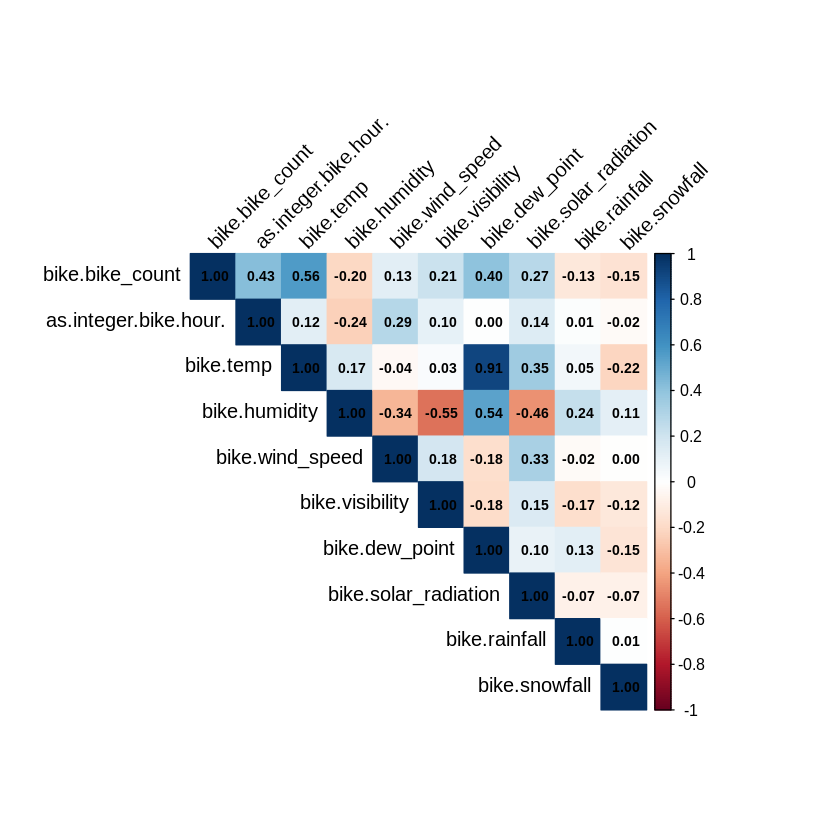

In [ ]:
corrplot(cor_matrix, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45,
         addCoef.col = "black", # Add correlation coefficient
         number.cex = 0.7)      # Adjust text size

From the correlation matrix we can determine all the below points.

- the target value bike_count’s correlation can be seen in order of ``temp``, ``hour``, ``dew_point``, ``solar_radiation`` and so on.

- ``dew_point`` has high correlation with temp which may be problematic in constructing good models.

- ``bike_count`` has low correlation with each individual factors showing predicting bike demand is affected by more than one factor.

We will be doing further analysis of this in each model’s multicollinearity section.

Below is the histograms of continuous data to determine the shape of the variables. Some of the keytakes are

- It can be seen that ``bike_count`` values are right-skewed.

- There are a lot of hours with temperature below zero, which we expect these hours to have lower demand for bike rentals.

- The humidity histogram shows that the data is more of normally distributed compared to the rest of the factors.

- Windspeed is low with very few extreme speeds.

- Visibility good on most of the days. Dew point temperature shows similar distribution to temperature.

- Solar radiation is 0 on most hours with very few hours with extrememe values.

- Rainfall and snowfall data is extremely skewed to the right with very few hours with high levels of rain and snow.

- The temperature shows signs of having a bimodal distribution.

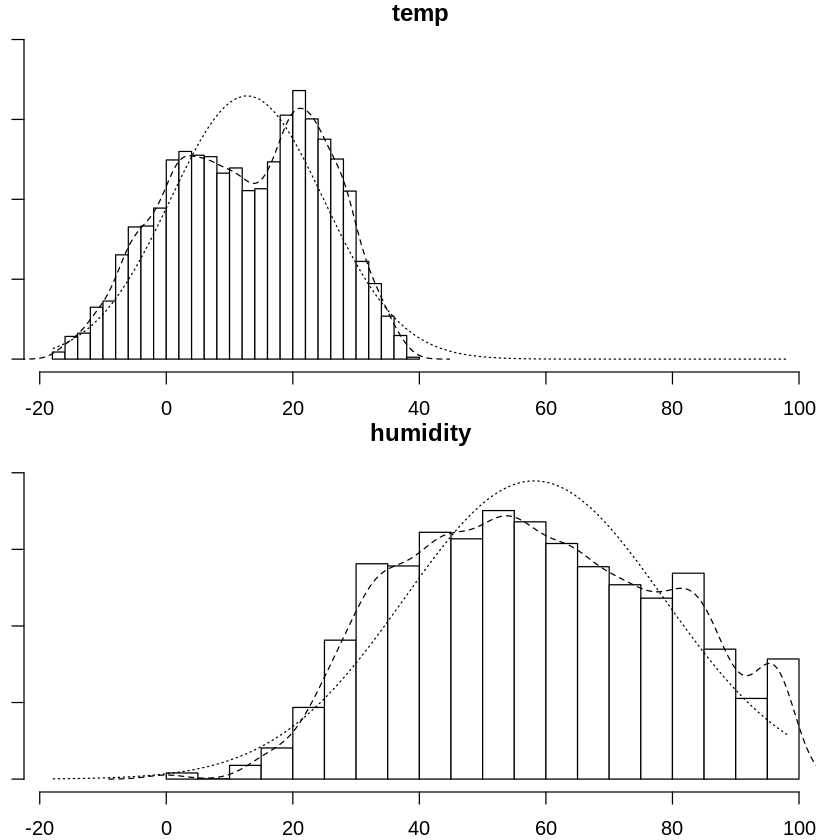

In [ ]:
selected_vars <- bike[, c("temp", "humidity")]
multi.hist(bike[, c("temp", "humidity")])

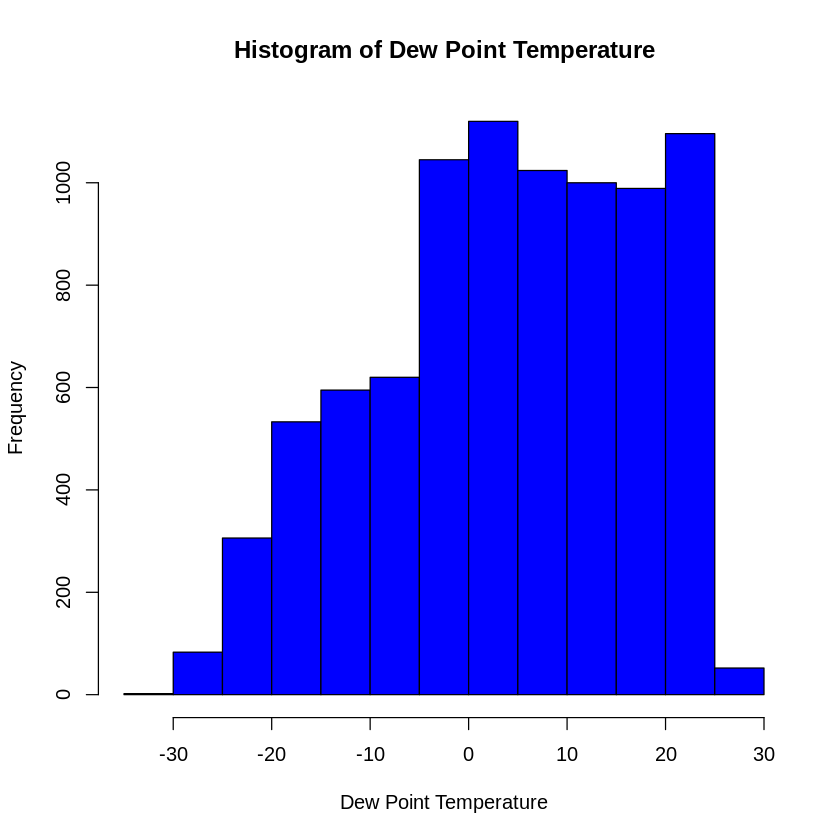

In [ ]:
hist(bike$dew_point_temp, main = "Histogram of Dew Point Temperature",
     xlab = "Dew Point Temperature",
     ylab = "Frequency",
     col = "blue")

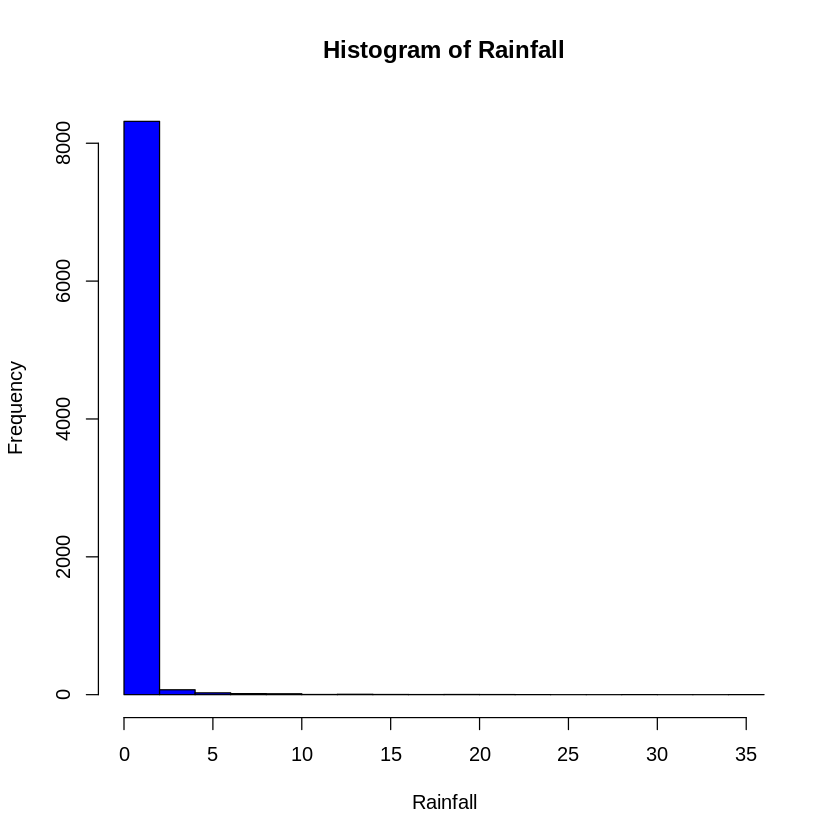

In [ ]:
hist(bike$rainfall, main = "Histogram of Rainfall",
     xlab = "Rainfall",
     ylab = "Frequency",
     col = "blue")

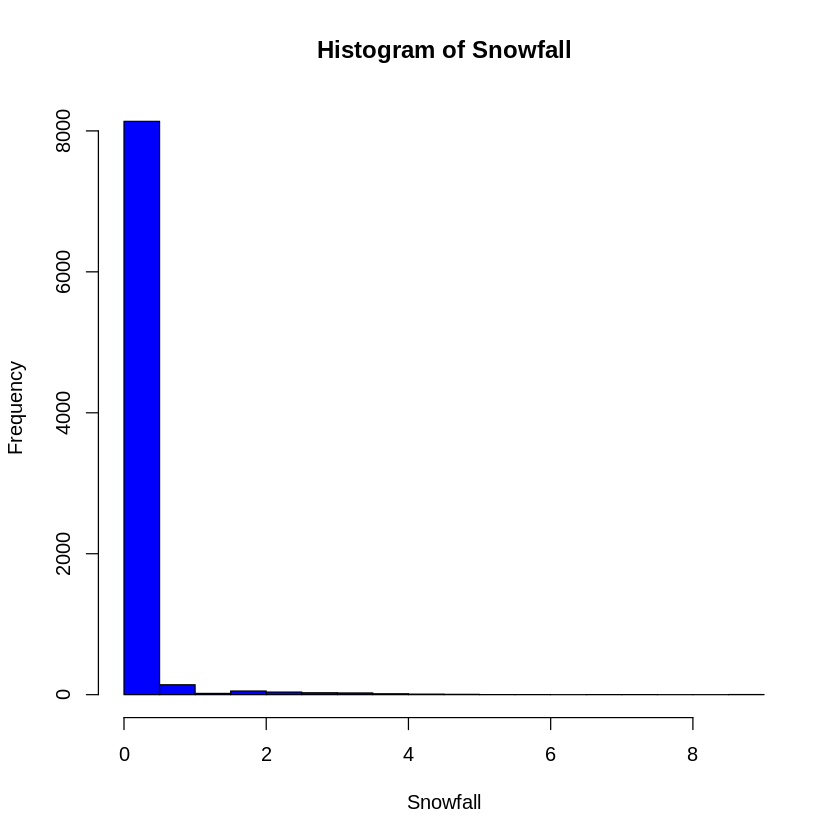

In [ ]:
hist(bike$snowfall, main = "Histogram of Snowfall",
     xlab = "Snowfall",
     ylab = "Frequency",
     col = "blue")

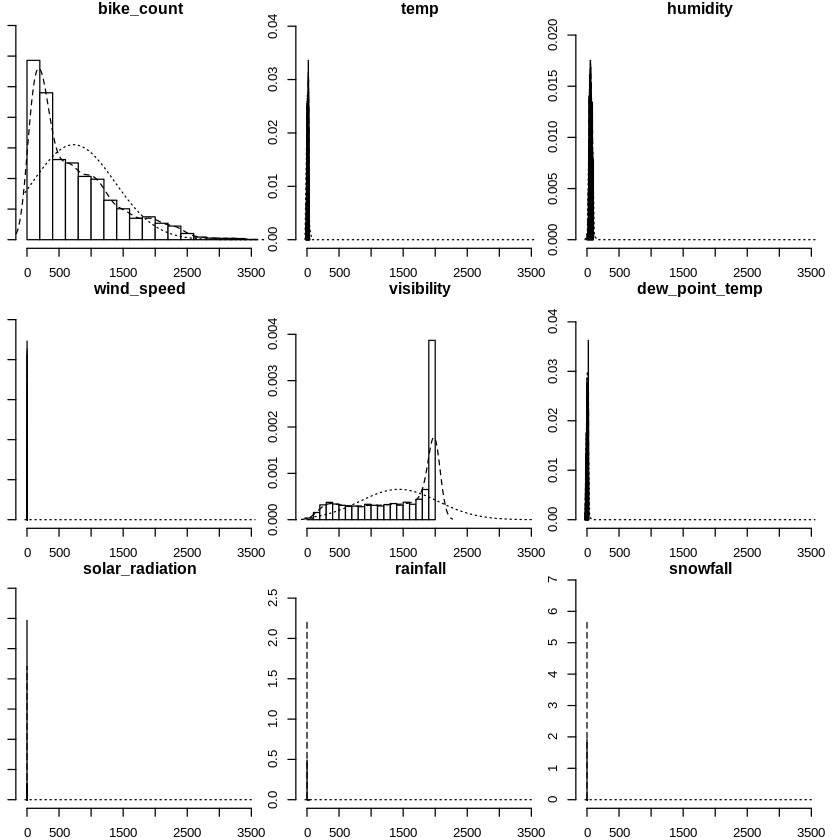

In [ ]:
# Creating histograms
multi.hist(bike[,sapply(bike, is.numeric)])

# Scatter Plot

The three scatter plot below show the relation betwen each of Temperature, Rainfall and Solar Radiation to the target variable Bike Rental Count.

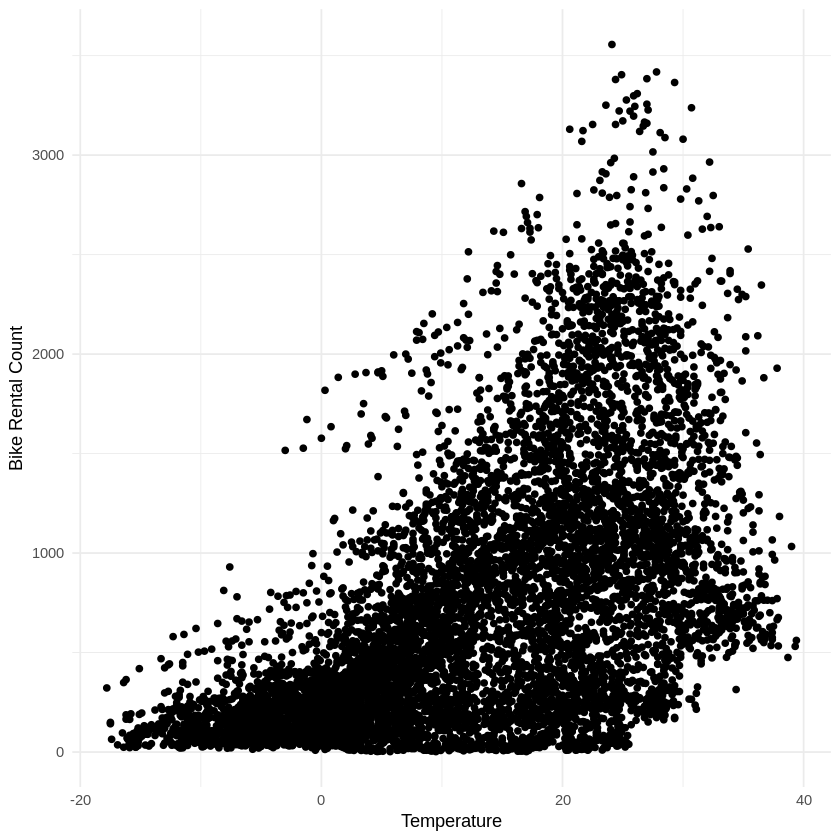

In [ ]:
ggplot(bike, aes(x = temp, y = bike_count)) +
  geom_point() +
  labs(x = "Temperature", y = "Bike Rental Count") +
  theme_minimal()

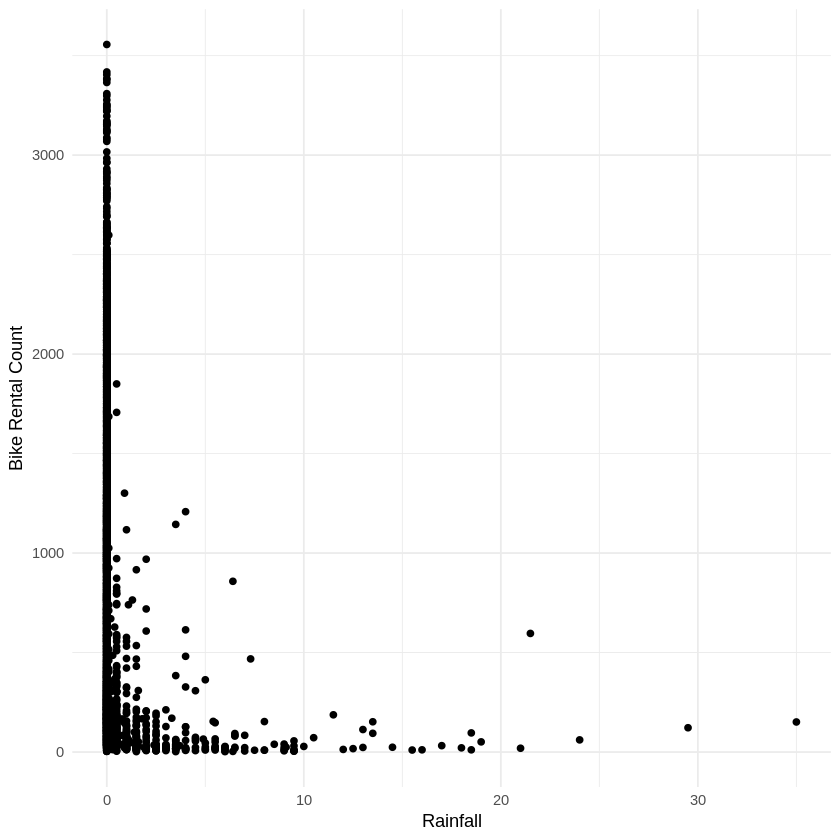

In [ ]:
ggplot(bike, aes(x = rainfall, y = bike_count)) +
  geom_point() +
  labs(x = "Rainfall", y = "Bike Rental Count") +
  theme_minimal()

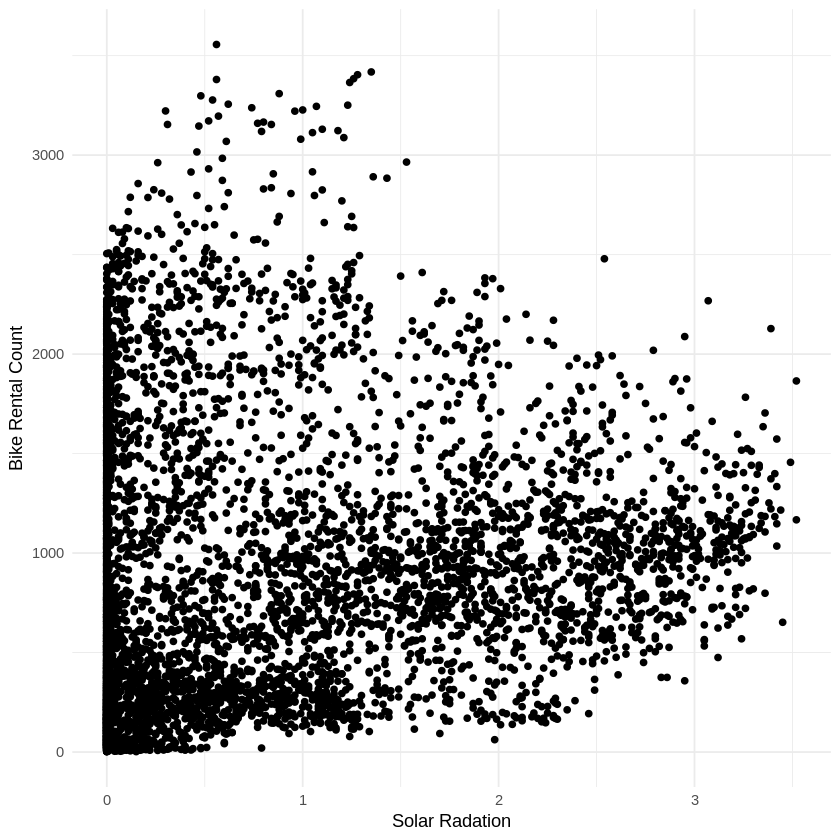

In [ ]:
ggplot(bike, aes(x = solar_radiation, y = bike_count)) +
  geom_point() +
  labs(x = "Solar Radation", y = "Bike Rental Count") +
  theme_minimal()